In [1]:
from pathlib import Path

DATA = Path("../data")      # notebooks/ → ../data 로 올라가게
(DATA/"raw").mkdir(parents=True, exist_ok=True)
(DATA/"network").mkdir(parents=True, exist_ok=True)
DATA

PosixPath('../data')

In [5]:
import osmnx as ox
print(ox.__version__)

2.0.6


In [11]:
import osmnx as ox, sys, pathlib
print("OSMnx:", ox.__version__)
print("CWD:", pathlib.Path.cwd())

OSMnx: 2.0.6
CWD: /Users/ieunseo/Desktop/adrenaline-proto/notebooks


In [13]:
# 제주시 데이터에는 surface, foot 속성이 아예 없는 엣지가 많아서 그 컬럼을 선택하려다 KeyError
#OSM은 지역·태깅 상태에 따라 컬럼이 없을 수 있음 
from pathlib import Path
import osmnx as ox
import geopandas as gpd

# OSMnx 2.x 설정
ox.settings.log_console = True
ox.settings.use_cache = True

# 1) 제주시 보행 네트워크 가져오기
G = ox.graph_from_place("제주시, 제주특별자치도, 대한민국", network_type="walk", simplify=True)
print("nodes:", len(G.nodes), "edges:", len(G.edges))

# 2) 저장 폴더
OUT_DIR = Path("./data/network/jeju_walk"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# 3) 노드/엣지 GDF로 변환
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
nodes_gdf = nodes_gdf.to_crs(epsg=4326)
edges_gdf = edges_gdf.to_crs(epsg=4326)
edges_gdf["shape_type"] = edges_gdf.geometry.geom_type

# 4) Shapefile 저장 (2.x 권장 방식: GDF.to_file)
nodes_gdf.to_file(OUT_DIR / "nodes.shp")
edges_gdf.to_file(OUT_DIR / "edges.shp")

# 5) GeoJSON(우리 파이프라인에 바로 쓰기 쉬움)
edges_gdf[["geometry","highway","name","surface","foot","access","bridge","tunnel","shape_type"]]\
    .to_file(OUT_DIR / "pedestrian.geojson", driver="GeoJSON")

# 6) GraphML (버전에 따라 io 네임스페이스)
graphml_path = OUT_DIR / "jeju_walk.graphml"
if hasattr(ox, "save_graphml"):
    ox.save_graphml(G, filepath=str(graphml_path))
else:
    ox.io.save_graphml(G, filepath=str(graphml_path))

print("saved to:", OUT_DIR.resolve())
list(OUT_DIR.glob("*"))

nodes: 23071 edges: 66404


/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_30534/2735252110.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_gdf.to_file(OUT_DIR / "nodes.shp")
/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'street_count' to 'street_cou'
  ogr_write(
/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value '[369907074, 369907075, 369907076, 369907077, 369907078, 369151748, 369155753, 369155757, 369155758, 369155759, 369155760, 369155761, 369155762, 369155763, 369155764, 369155765, 369155766, 369155767, 369155768, 369155769, 369907782, 369907788, 372845796, 369907051]' of field osmid has been truncated to 254 characters.  This warning will not be emitted any more for that layer.
  ogr_write(


KeyError: "['surface', 'foot'] not in index"

In [15]:
from pathlib import Path
import osmnx as ox
import geopandas as gpd

# 1) 그래프 → GDF
G = ox.graph_from_place("제주시, 제주특별자치도, 대한민국", network_type="walk", simplify=True)
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
edges_gdf = edges_gdf.to_crs(epsg=4326)

# 2) 필요한 컬럼 보정: 없으면 추가
wanted = ["highway","name","surface","foot","access","bridge","tunnel"]
for c in wanted:
    if c not in edges_gdf.columns:
        edges_gdf[c] = None

# 3) shape_type 추가
edges_gdf["shape_type"] = edges_gdf.geometry.geom_type

# 4) 저장
OUT_DIR = Path("./data/network/jeju_walk"); OUT_DIR.mkdir(parents=True, exist_ok=True)
keep_cols = ["geometry"] + wanted + ["shape_type"]
edges_gdf[keep_cols].to_file(OUT_DIR / "pedestrian.geojson", driver="GeoJSON")

# (선택) Shapefile도 저장
nodes_gdf.to_file(OUT_DIR / "nodes.shp")
edges_gdf.to_file(OUT_DIR / "edges.shp")

# (선택) GraphML
ox.save_graphml(G, filepath=str(OUT_DIR / "jeju_walk.graphml"))

print("저장됨:", list(OUT_DIR.glob("*")))


/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_30534/2553868619.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_gdf.to_file(OUT_DIR / "nodes.shp")
/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'street_count' to 'street_cou'
  ogr_write(
/opt/anaconda3/envs/adrenaline-proto/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value '[369907074, 369907075, 369907076, 369907077, 369907078, 369151748, 369155753, 369155757, 369155758, 369155759, 369155760, 369155761, 369155762, 369155763, 369155764, 369155765, 369155766, 369155767, 369155768, 369155769, 369907782, 369907788, 372845796, 369907051]' of field osmid has been truncated to 254 characters.  This warning will not be emitted any more for that layer.
  ogr_write(


저장됨: [PosixPath('data/network/jeju_walk/pedestrian.geojson'), PosixPath('data/network/jeju_walk/edges.dbf'), PosixPath('data/network/jeju_walk/nodes.prj'), PosixPath('data/network/jeju_walk/edges.shp'), PosixPath('data/network/jeju_walk/edges.cpg'), PosixPath('data/network/jeju_walk/edges.shx'), PosixPath('data/network/jeju_walk/jeju_walk.graphml'), PosixPath('data/network/jeju_walk/nodes.shx'), PosixPath('data/network/jeju_walk/nodes.shp'), PosixPath('data/network/jeju_walk/nodes.cpg'), PosixPath('data/network/jeju_walk/edges.prj'), PosixPath('data/network/jeju_walk/nodes.dbf')]


In [17]:
import geopandas as gpd
gdf = gpd.read_file("data/network/jeju_walk/pedestrian.geojson")
gdf.head()

Skipping field highway: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5


,u,v,key,surface,foot,access,bridge,tunnel,shape_type,geometry
0,414679035,2823930336,0,None,None,None,None,None,LineString,"LINESTRING (126.26934 33.40488, 126.26941 33.4..."
1,414679035,2823956648,0,None,None,None,None,None,LineString,"LINESTRING (126.26934 33.40488, 126.26923 33.4..."
2,414679035,2808553838,0,None,None,None,None,None,LineString,"LINESTRING (126.26934 33.40488, 126.26945 33.4..."
3,414679035,2823956693,0,None,None,None,None,None,LineString,"LINESTRING (126.26934 33.40488, 126.26928 33.4..."
4,414679037,12709535501,0,None,None,None,None,None,LineString,"LINESTRING (126.2636 33.3987, 126.26358 33.39897)"


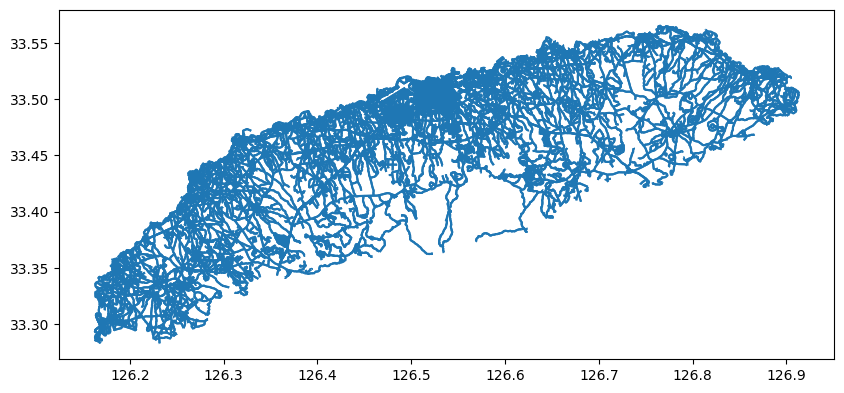

In [19]:
import matplotlib.pyplot as plt
gdf.plot(figsize=(10,10))
plt.show()

In [21]:
from svgpathtools import svg2paths2
import numpy as np
from shapely.geometry import LineString, MultiLineString
import geopandas as gpd
from pathlib import Path
from math import cos, radians

def svg_to_lines(svg_path: str,
                 samples_per_path: int = 400,
                 use_subpaths: bool = True,
                 flip_y: bool = True):
    """
    SVG의 path들을 샘플링하여 화면좌표(x,y) 폴리라인 리스트로 반환
    - viewBox로 정규화하여 (0~1) 범위로 맞춘 뒤 반환
    - flip_y=True면 SVG 스크린 좌표계(y↓)를 수학좌표계(y↑)로 뒤집음
    """
    paths, attrs, svg_attrs = svg2paths2(svg_path)
    vb = svg_attrs.get("viewBox", None)
    if vb:
        x0, y0, w, h = map(float, vb.split())
    else:
        # viewBox가 없으면 width/height 사용 (px)
        w = float(svg_attrs.get("width", 1))
        h = float(svg_attrs.get("height", 1))
        x0, y0 = 0.0, 0.0

    lines = []
    for p in paths:
        # path를 구성하는 연속 구간들을 개별 polyline으로
        subpaths = p.continuous_subpaths() if use_subpaths else [p]
        for sp in subpaths:
            ts = np.linspace(0, 1, samples_per_path)
            xy = np.array([[complex(sp.point(t)).real, complex(sp.point(t)).imag] for t in ts])

            # viewBox 기준 정규화 (0~1)
            x = (xy[:,0] - x0) / w
            y = (xy[:,1] - y0) / h
            if flip_y:  # 화면 y축 아래방향 → 수학좌표계 위쪽
                y = 1 - y

            # 0~1 범위 라인을 LineString으로
            line = LineString(np.column_stack([x, y]))
            if not line.is_empty:
                lines.append(line)

    if not lines:
        return None
    return MultiLineString(lines) if len(lines) > 1 else lines[0]


In [23]:
def normalized_to_wgs84(geom,
                        lon0: float, lat0: float,
                        size_m: float = 1000.0,
                        rotation_deg: float = 0.0):
    """
    (0~1) 정규화 좌표를 중심(lon0,lat0) 주변에 'size_m' 크기로 배치한 WGS84 LineString/MultiLineString 반환
    - size_m: 도형의 가로/세로 평균 크기(미터). 정사각형으로 가정
    - rotation_deg: 시계 반대(+)
    """
    # 중심 기준 [-0.5, 0.5]로 이동
    def _to_xy(arr):
        # arr: (N,2) in [0,1]
        xy = arr - 0.5  # 중심화
        # 회전
        th = radians(rotation_deg)
        R = np.array([[np.cos(th), -np.sin(th)],
                      [np.sin(th),  np.cos(th)]])
        xy = xy @ R.T
        # 미터 스케일
        # 위도 1도 ≈ 111_320 m, 경도 1도 ≈ 111_320 * cos(lat)
        m_per_deg_lat = 111_320.0
        m_per_deg_lon = 111_320.0 * cos(radians(lat0))
        # size_m가 전체 폭(=1.0)에 해당하도록 스케일
        sx_deg = (size_m / m_per_deg_lon)
        sy_deg = (size_m / m_per_deg_lat)
        lon = lon0 + xy[:,0] * sx_deg
        lat = lat0 + xy[:,1] * sy_deg
        return np.column_stack([lon, lat])

    if isinstance(geom, LineString):
        arr = np.array(geom.coords)
        return LineString(_to_xy(arr))
    elif isinstance(geom, MultiLineString):
        return MultiLineString([LineString(_to_xy(np.array(ls.coords))) for ls in geom.geoms])
    else:
        raise TypeError("LineString/MultiLineString만 지원합니다.")


In [31]:
# 입력/출력 경로
SVG = "../data/templates/star.svg"      # ← 네 SVG 경로로 바꿔줘
OUT_DIR = Path("../data/templates"); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_GJ = OUT_DIR / "star.geojson"

# 3-1) SVG를 폴리라인으로
geom_norm = svg_to_lines(SVG, samples_per_path=600, use_subpaths=True, flip_y=True)

# 3-2) 제주시 주변에 배치 (중심/크기/회전 조절 가능)
# 제주대학교 공과대학 4호관 좌표
lon0, lat0 = 126.564018, 33.452345   # 공대4호관 중심

geom_wgs = normalized_to_wgs84(
    geom_norm,
    lon0, lat0,
    size_m=1500,       # 도형 크기(미터). 필요시 500~3000 정도로 조절
    rotation_deg=0     # SVG 방향 맞추고 싶으면 각도 넣기
)

gdf = gpd.GeoDataFrame({"name": ["star"]}, geometry=[geom_wgs], crs="EPSG:4326")
gdf.to_file("../data/templates/star.geojson", driver="GeoJSON")

In [35]:
import osmnx as ox
import geopandas as gpd
from shapely.ops import nearest_points
import numpy as np

# 우리가 저장해둔 GraphML 불러오기
G = ox.load_graphml("../data/network/jeju_walk/jeju_walk.graphml")
nodes, edges = ox.graph_to_gdfs(G)
print(nodes.head())
print(edges.head())

# star.geojson 불러오기
template = gpd.read_file("../data/templates/star.geojson")
template = template.to_crs(edges.crs)  # 네트워크와 좌표계 맞추기
template_line = template.geometry.iloc[0]  # 단일 도형

#Line → 네트워크 노드 ID 매칭
def snap_to_nearest_nodes(line, nodes_gdf):
    # 라인을 일정 간격으로 샘플링
    distances = np.linspace(0, line.length, 100)
    points = [line.interpolate(d) for d in distances]
    snapped = []
    for pt in points:
        # 가장 가까운 노드 찾기
        nearest_idx = nodes_gdf.geometry.distance(pt).idxmin()
        snapped.append(nodes_gdf.loc[nearest_idx].name)  # node ID
    return snapped

snapped_ids = snap_to_nearest_nodes(template_line, nodes)
print(snapped_ids[:10])
# 이렇게 하면 Polyline을 따라간 node id 리스트가 생기고
# FMM 입력의 source/target 열로 넣을 수 있음

                   y           x junction  street_count highway  ref  \
osmid                                                                  
414679035  33.404882  126.269344      yes             4     NaN  NaN   
414679037  33.398700  126.263599      yes             4     NaN  NaN   
414679042  33.387787  126.248973      yes             4     NaN  NaN   
414679043  33.382148  126.235792      yes             4     NaN  NaN   
414679057  33.343236  126.182761      yes             3     NaN  NaN   

                             geometry  
osmid                                  
414679035  POINT (126.26934 33.40488)  
414679037    POINT (126.2636 33.3987)  
414679042  POINT (126.24897 33.38779)  
414679043  POINT (126.23579 33.38215)  
414679057  POINT (126.18276 33.34324)  
                               osmid    highway   name   ref  oneway reversed  \
u         v           key                                                       
414679035 2823930336  0    352213846  secondary  한림중앙

/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_30534/1735544891.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = nodes_gdf.geometry.distance(pt).idxmin()
/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_30534/1735544891.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = nodes_gdf.geometry.distance(pt).idxmin()
/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_30534/1735544891.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = nodes_gdf.geometry.distance(pt).idxmin()
/var/folders/xg/n07cc3254

[np.int64(1087927751), np.int64(1087928325), np.int64(1087930420), np.int64(1087930101), np.int64(1087928452), np.int64(1087928107), np.int64(1087930388), np.int64(2897246462), np.int64(4655287890), np.int64(3687619325)]


/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_30534/1735544891.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = nodes_gdf.geometry.distance(pt).idxmin()
/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_30534/1735544891.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = nodes_gdf.geometry.distance(pt).idxmin()
/var/folders/xg/n07cc3254sdcw3q71k1w0j880000gn/T/ipykernel_30534/1735544891.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = nodes_gdf.geometry.distance(pt).idxmin()
/var/folders/xg/n07cc3254

In [39]:
import geopandas as gpd
from pathlib import Path

# edges: ox.graph_to_gdfs(G)로 얻은 엣지 GDF라고 가정
# 1) 인덱스(u,v,key)를 컬럼으로 빼오기
edges_cols = edges.reset_index()  # ★ drop 쓰지 마세요

# 2) FMM이 요구하는 컬럼 구성 (source/target/id/geometry)
edges_fmm = edges_cols.rename(columns={"u": "source", "v": "target"}).copy()
edges_fmm["id"] = edges_fmm.index.astype(int)

# 3) (권장) 좌표계 WGS84 확인/변환
edges_fmm = edges_fmm.to_crs(epsg=4326)

# 4) 저장
out = Path("../data/network/jeju_walk"); out.mkdir(parents=True, exist_ok=True)
edges_fmm[["id", "source", "target", "geometry"]].to_file(out / "edges_uv.shp")

print("saved:", (out / "edges_uv.shp").resolve())
print(edges_fmm[["id","source","target"]].head())


saved: /Users/ieunseo/Desktop/adrenaline-proto/data/network/jeju_walk/edges_uv.shp
   id     source       target
0   0  414679035   2823930336
1   1  414679035   2823956648
2   2  414679035   2808553838
3   3  414679035   2823956693
4   4  414679037  12709535501
